In [ ]:
import pandas as pd
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from datetime import datetime
from sklearn.metrics import log_loss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
%matplotlib inline

In [ ]:
!pip install kaggle
from google.colab import files
from datetime import datetime
api_token = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c home-credit-default-risk

#sample_submission.csv
#HomeCredit_columns_description.csv
#installments_payments.csv.zip
#bureau.csv.zip
#POS_CASH_balance.csv.zip
#application_test.csv.zip
#bureau_balance.csv.zip
#previous_application.csv.zip
#application_train.csv.zip
#credit_card_balance.csv.zip

credit_card_balance.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
bureau.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
previous_application.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
installments_payments.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
POS_CASH_balance.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
HomeCredit_columns_description.csv: Skipping, found more recently modified local copy (use --force to force download)
bureau_balance.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
application_train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
application_test.csv

In [ ]:
df = pd.read_csv('HomeCredit_columns_description.csv', encoding = "ISO-8859-1")
df.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [ ]:
!unzip application_train.csv.zip
!unzip bureau.csv.zip
!unzip bureau_balance.csv.zip
!unzip POS_CASH_balance.csv.zip
!unzip application_test.csv.zip
!unzip previous_application.csv.zip
!unzip credit_card_balance.csv.zip

Archive:  application_train.csv.zip
  inflating: application_train.csv   
Archive:  bureau.csv.zip
  inflating: bureau.csv              
Archive:  bureau_balance.csv.zip
  inflating: bureau_balance.csv      
Archive:  POS_CASH_balance.csv.zip
  inflating: POS_CASH_balance.csv    
Archive:  application_test.csv.zip
  inflating: application_test.csv    
Archive:  previous_application.csv.zip
  inflating: previous_application.csv  
Archive:  credit_card_balance.csv.zip
  inflating: credit_card_balance.csv  


In [ ]:
app_train = pd.read_csv('application_train.csv', encoding = "ISO-8859-1")
print(app_train.shape)
app_train.head(5)

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
prev_app = pd.read_csv('previous_application.csv')
print(prev_app.shape)
prev_app.head()

(1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
prev_app_cash_bal = pd.read_csv('POS_CASH_balance.csv')
print(prev_app_cash_bal.shape)
prev_app_cash_bal.head()

(10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [ ]:
app_train_joinwith_prev_app_df = pd.merge(app_train, prev_app, how='left', on='SK_ID_CURR')

# **Data Preparation**

In [ ]:
def getNumericalAndCategoricalColumnsOfDf(df):
  s = (df.dtypes != 'object')
  numeric_cols = list(s[s].index)
  s = (df.dtypes == 'object')
  object_cols = list(s[s].index)
  return numeric_cols, object_cols

def getLabelEncodedDataframe(df, cols):
  le = LabelEncoder()
  encoded_df = pd.DataFrame()
  for col in cols:
    # print(col)
    # print(df[col].astype(str))
    encoded_df[col+'_L'] = le.fit_transform(df[col].astype(str))
    # print(encoded_df[col+'_L'].value_counts())
  
  return encoded_df

In [ ]:
numeric_cols, object_cols = getNumericalAndCategoricalColumnsOfDf(prev_app_cash_bal)
print("Numeric variables:")
print(len(numeric_cols), numeric_cols)  

print("Categorical variables:")
print(len(object_cols), object_cols)

Numeric variables:
7 ['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'SK_DPD', 'SK_DPD_DEF']
Categorical variables:
1 ['NAME_CONTRACT_STATUS']


In [ ]:
encoded_df = getLabelEncodedDataframe(prev_app_cash_bal, object_cols)
# print(enc_df)
prev_app_cash_bal_df = pd.concat([prev_app_cash_bal[numeric_cols], encoded_df], axis=1)

prev_app_cash_bal_df = prev_app_cash_bal_df.drop(columns=['SK_ID_CURR'])
prev_app_cash_bal_df.sort_values(by=['SK_ID_PREV']).head()

,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_L
45995,1000001,-8,2.0,0.0,0,0,4
6030662,1000001,-10,12.0,12.0,0,0,0
8470736,1000001,-9,12.0,11.0,0,0,0
2658581,1000002,-51,6.0,1.0,0,0,0
2549591,1000002,-52,6.0,2.0,0,0,0


In [ ]:
prev_app_cash_bal_df_median = prev_app_cash_bal_df.groupby('SK_ID_PREV').median()
prev_app_cash_bal_df_median = prev_app_cash_bal_df_median.add_suffix('_MED')
print(prev_app_cash_bal_df_median.columns)
prev_app_cash_bal_df_median.head()

Index(['MONTHS_BALANCE_MED', 'CNT_INSTALMENT_MED', 'CNT_INSTALMENT_FUTURE_MED',
       'SK_DPD_MED', 'SK_DPD_DEF_MED', 'NAME_CONTRACT_STATUS_L_MED'],
      dtype='object')


,MONTHS_BALANCE_MED,CNT_INSTALMENT_MED,CNT_INSTALMENT_FUTURE_MED,SK_DPD_MED,SK_DPD_DEF_MED,NAME_CONTRACT_STATUS_L_MED
SK_ID_PREV,,,,,,
1000001,-9.0,12.0,11.0,0.0,0.0,0.0
1000002,-52.0,6.0,2.0,0.0,0.0,0.0
1000003,-2.5,12.0,10.5,0.0,0.0,0.0
1000004,-25.5,10.0,6.5,0.0,0.0,0.0
1000005,-51.0,10.0,5.0,0.0,0.0,0.0


In [ ]:
numeric_cols, object_cols = getNumericalAndCategoricalColumnsOfDf(prev_app)
print("Numeric variables:")
print(len(numeric_cols), numeric_cols)  

print("Categorical variables:")
print(len(object_cols), object_cols)

Numeric variables:
21 ['SK_ID_PREV', 'SK_ID_CURR', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']
Categorical variables:
16 ['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION']


In [ ]:
encoded_df = getLabelEncodedDataframe(prev_app, object_cols)
prev_app_df = pd.concat([prev_app[numeric_cols], encoded_df], axis=1)
# prev_app_df = prev_app_df.drop(columns=['SK_ID_PREV'])
print(prev_app_df.shape)
prev_app_df.head()

(1670214, 37)


,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NAME_CONTRACT_TYPE_L,WEEKDAY_APPR_PROCESS_START_L,FLAG_LAST_APPL_PER_CONTRACT_L,NAME_CASH_LOAN_PURPOSE_L,NAME_CONTRACT_STATUS_L,NAME_PAYMENT_TYPE_L,CODE_REJECT_REASON_L,NAME_TYPE_SUITE_L,NAME_CLIENT_TYPE_L,NAME_GOODS_CATEGORY_L,NAME_PORTFOLIO_L,NAME_PRODUCT_TYPE_L,CHANNEL_TYPE_L,NAME_SELLER_INDUSTRY_L,NAME_YIELD_GROUP_L,PRODUCT_COMBINATION_L
0,2030495,271877,1730.430,17145.0,17145.0,0.0,17145.0,15,1,0.0,0.182832,0.867336,-73,35,12.0,365243.0,-42.0,300.0,-42.0,-37.0,0.0,1,2,1,23,0,0,7,7,2,19,3,0,4,2,4,13
1,2802425,108129,25188.615,607500.0,679671.0,NaN,607500.0,11,1,NaN,NaN,NaN,-164,-1,36.0,365243.0,-134.0,916.0,365243.0,365243.0,1.0,0,4,1,24,0,3,7,6,2,27,2,2,3,10,2,7
2,2523466,122040,15060.735,112500.0,136444.5,NaN,112500.0,11,1,NaN,NaN,NaN,-301,-1,12.0,365243.0,-271.0,59.0,365243.0,365243.0,1.0,0,5,1,24,0,0,7,5,2,27,2,2,5,10,1,6
3,2819243,176158,47041.335,450000.0,470790.0,NaN,450000.0,7,1,NaN,NaN,NaN,-512,-1,12.0,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,0,1,1,24,0,0,7,7,2,27,2,2,5,10,4,8
4,1784265,202054,31924.395,337500.0,404055.0,NaN,337500.0,9,1,NaN,NaN,NaN,-781,-1,24.0,NaN,NaN,NaN,NaN,NaN,NaN,0,4,1,20,2,0,1,7,2,27,2,1,5,10,1,3


In [ ]:
prev_app_with_prev_balance_df = pd.merge(prev_app_df, prev_app_cash_bal_df_median, how='left', on='SK_ID_PREV')
print(prev_app_with_prev_balance_df.shape)
prev_app_with_prev_balance_df.head()

(1670214, 43)


,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NAME_CONTRACT_TYPE_L,WEEKDAY_APPR_PROCESS_START_L,FLAG_LAST_APPL_PER_CONTRACT_L,NAME_CASH_LOAN_PURPOSE_L,NAME_CONTRACT_STATUS_L,NAME_PAYMENT_TYPE_L,CODE_REJECT_REASON_L,NAME_TYPE_SUITE_L,NAME_CLIENT_TYPE_L,NAME_GOODS_CATEGORY_L,NAME_PORTFOLIO_L,NAME_PRODUCT_TYPE_L,CHANNEL_TYPE_L,NAME_SELLER_INDUSTRY_L,NAME_YIELD_GROUP_L,PRODUCT_COMBINATION_L,MONTHS_BALANCE_MED,CNT_INSTALMENT_MED,CNT_INSTALMENT_FUTURE_MED,SK_DPD_MED,SK_DPD_DEF_MED,NAME_CONTRACT_STATUS_L_MED
0,2030495,271877,1730.430,17145.0,17145.0,0.0,17145.0,15,1,0.0,0.182832,0.867336,-73,35,12.0,365243.0,-42.0,300.0,-42.0,-37.0,0.0,1,2,1,23,0,0,7,7,2,19,3,0,4,2,4,13,-1.5,6.5,6.0,0.0,0.0,2.0
1,2802425,108129,25188.615,607500.0,679671.0,NaN,607500.0,11,1,NaN,NaN,NaN,-164,-1,36.0,365243.0,-134.0,916.0,365243.0,365243.0,1.0,0,4,1,24,0,3,7,6,2,27,2,2,3,10,2,7,-4.0,36.0,34.0,0.0,0.0,0.0
2,2523466,122040,15060.735,112500.0,136444.5,NaN,112500.0,11,1,NaN,NaN,NaN,-301,-1,12.0,365243.0,-271.0,59.0,365243.0,365243.0,1.0,0,5,1,24,0,0,7,5,2,27,2,2,5,10,1,6,-5.5,12.0,7.5,0.0,0.0,0.0
3,2819243,176158,47041.335,450000.0,470790.0,NaN,450000.0,7,1,NaN,NaN,NaN,-512,-1,12.0,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,0,1,1,24,0,0,7,7,2,27,2,2,5,10,4,8,-11.5,12.0,6.5,0.0,0.0,0.0
4,1784265,202054,31924.395,337500.0,404055.0,NaN,337500.0,9,1,NaN,NaN,NaN,-781,-1,24.0,NaN,NaN,NaN,NaN,NaN,NaN,0,4,1,20,2,0,1,7,2,27,2,1,5,10,1,3,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
prev_app_with_prev_balance_df['NAME_CONTRACT_STATUS_L'].value_counts()

0    1036781
1     316319
2     290678
3      26436
Name: NAME_CONTRACT_STATUS_L, dtype: int64

In [ ]:
np.sort(prev_app_with_prev_balance_df['SK_ID_CURR'].to_list())[0:10]

array([100001, 100002, 100003, 100003, 100003, 100004, 100005, 100005,
       100006, 100006])

In [ ]:
# prev_app_with_prev_balance_df.head()
prev_app_with_prev_balance_df.sort_values(by=['SK_ID_CURR']).head(10)[['NAME_CONTRACT_STATUS_L','SK_ID_CURR']]

,NAME_CONTRACT_STATUS_L,SK_ID_CURR
201668,0,100001
892077,0,100002
575941,0,100003
1021650,0,100003
1223745,0,100003
935548,0,100004
1259112,1,100005
1378978,0,100005
900957,0,100006
1607443,2,100006


In [ ]:
# prev_app_with_prev_balance_df[prev_app_with_prev_balance_df['SK_ID_CURR'] == '100005    ']
# prev_app_with_prev_balance_df.loc[prev_app_with_prev_balance_df['SK_ID_CURR'] == '100005','NAME_CONTRACT_STATUS_L']

In [ ]:
# prev_app_with_prev_balance_df_median = prev_app_with_prev_balance_df.groupby('SK_ID_CURR')['NAME_CONTRACT_STATUS_L'].median()

In [ ]:
# prev_app_with_prev_balance_df_median.head()

In [ ]:
prev_app_with_prev_balance_df_median = prev_app_with_prev_balance_df.groupby('SK_ID_CURR').median()
prev_app_with_prev_balance_df_median = prev_app_with_prev_balance_df_median.add_suffix('_MED2')
prev_app_with_prev_balance_df_median.head()

,SK_ID_PREV_MED2,AMT_ANNUITY_MED2,AMT_APPLICATION_MED2,AMT_CREDIT_MED2,AMT_DOWN_PAYMENT_MED2,AMT_GOODS_PRICE_MED2,HOUR_APPR_PROCESS_START_MED2,NFLAG_LAST_APPL_IN_DAY_MED2,RATE_DOWN_PAYMENT_MED2,RATE_INTEREST_PRIMARY_MED2,RATE_INTEREST_PRIVILEGED_MED2,DAYS_DECISION_MED2,SELLERPLACE_AREA_MED2,CNT_PAYMENT_MED2,DAYS_FIRST_DRAWING_MED2,DAYS_FIRST_DUE_MED2,DAYS_LAST_DUE_1ST_VERSION_MED2,DAYS_LAST_DUE_MED2,DAYS_TERMINATION_MED2,NFLAG_INSURED_ON_APPROVAL_MED2,NAME_CONTRACT_TYPE_L_MED2,WEEKDAY_APPR_PROCESS_START_L_MED2,FLAG_LAST_APPL_PER_CONTRACT_L_MED2,NAME_CASH_LOAN_PURPOSE_L_MED2,NAME_CONTRACT_STATUS_L_MED2,NAME_PAYMENT_TYPE_L_MED2,CODE_REJECT_REASON_L_MED2,NAME_TYPE_SUITE_L_MED2,NAME_CLIENT_TYPE_L_MED2,NAME_GOODS_CATEGORY_L_MED2,NAME_PORTFOLIO_L_MED2,NAME_PRODUCT_TYPE_L_MED2,CHANNEL_TYPE_L_MED2,NAME_SELLER_INDUSTRY_L_MED2,NAME_YIELD_GROUP_L_MED2,PRODUCT_COMBINATION_L_MED2,MONTHS_BALANCE_MED_MED2,CNT_INSTALMENT_MED_MED2,CNT_INSTALMENT_FUTURE_MED_MED2,SK_DPD_MED_MED2,SK_DPD_DEF_MED_MED2,NAME_CONTRACT_STATUS_L_MED_MED2
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,1369693.0,3951.000,24835.50,23787.00,2520.0,24835.5,13.0,1.0,0.104326,NaN,NaN,-1740.0,23.0,8.0,365243.0,-1709.0,-1499.0,-1619.0,-1612.0,0.0,1.0,0.0,1.0,23.0,0.0,0.0,7.0,1.0,1.0,19.0,3.0,0.0,4.0,2.0,1.0,13.0,-55.0,4.0,2.0,0.0,0.0,0.0
100002,1038818.0,9251.775,179055.00,179055.00,0.0,179055.0,9.0,1.0,0.000000,NaN,NaN,-606.0,500.0,24.0,365243.0,-565.0,125.0,-25.0,-17.0,0.0,1.0,2.0,1.0,23.0,0.0,3.0,7.0,7.0,0.0,25.0,3.0,0.0,7.0,0.0,3.0,15.0,-10.0,24.0,15.0,0.0,0.0,0.0
100003,2396755.0,64567.665,337500.00,348637.50,3442.5,337500.0,15.0,1.0,0.050030,NaN,NaN,-828.0,200.0,12.0,365243.0,-797.0,-647.0,-647.0,-639.0,1.0,1.0,2.0,1.0,23.0,0.0,0.0,7.0,1.0,1.0,11.0,3.0,0.0,5.0,5.0,4.0,9.0,-24.5,12.0,6.5,0.0,0.0,0.0
100004,1564014.0,5357.250,24282.00,20106.00,4860.0,24282.0,5.0,1.0,0.212008,NaN,NaN,-815.0,30.0,4.0,365243.0,-784.0,-694.0,-724.0,-714.0,0.0,1.0,0.0,1.0,23.0,0.0,0.0,7.0,6.0,0.0,19.0,3.0,0.0,6.0,2.0,4.0,14.0,-25.5,4.0,2.5,0.0,0.0,0.0
100005,2176837.0,4813.200,22308.75,20076.75,4464.0,44617.5,10.5,1.0,0.108964,NaN,NaN,-536.0,18.0,12.0,365243.0,-706.0,-376.0,-466.0,-460.0,0.0,0.5,2.0,1.0,23.5,0.5,1.5,7.0,7.0,1.0,23.0,3.5,0.0,4.5,6.0,0.5,7.5,-20.0,12.0,7.5,0.0,0.0,0.0


In [ ]:
# prev_app_with_prev_balance_df_median['NAME_CONTRACT_STATUS_L_MED2'].value_counts()

In [ ]:
numeric_cols, object_cols = getNumericalAndCategoricalColumnsOfDf(app_train)
print("Numeric variables:")
print(len(numeric_cols), numeric_cols)  

print("Categorical variables:")
print(len(object_cols), object_cols)

encoded_df = getLabelEncodedDataframe(app_train, object_cols)

app_train_df = pd.concat([app_train[numeric_cols], encoded_df], axis=1)
# prev_app_df = prev_app_df.drop(columns=['SK_ID_PREV'])
print(app_train_df.shape)
app_train_df.head()

Numeric variables:
106 ['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEX

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_L,CODE_GENDER_L,FLAG_OWN_CAR_L,FLAG_OWN_REALTY_L,NAME_TYPE_SUITE_L,NAME_INCOME_TYPE_L,NAME_EDUCATION_TYPE_L,NAME_FAMILY_STATUS_L,NAME_HOUSING_TYPE_L,OCCUPATION_TYPE_L,WEEKDAY_APPR_PROCESS_START_L,ORGANIZATION_TYPE_L,FONDKAPREMONT_MODE_L,HOUSETYPE_MODE_L,WALLSMATERIAL_MODE_L,EMERGENCYSTATE_MODE_L
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0,1,6,7,4,3,1,8,6,5,3,0,5,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,4,1,1,1,3,1,39,3,0,0,0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,6,7,4,3,1,8,1,11,0,1,7,2
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,6,7,4,0,1,8,6,5,0,1,7,2
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,1,6,7,4,3,1,3,4,37,0,1,7,2


In [ ]:
app_train_with_prev_app_prev_balance_df = pd.merge(app_train_df, prev_app_with_prev_balance_df_median, how='left', on='SK_ID_CURR')
print(app_train_with_prev_app_prev_balance_df.shape)
app_train_with_prev_app_prev_balance_df.head()

(307511, 164)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,AMT_APPLICATION_MED2,AMT_CREDIT_MED2,AMT_DOWN_PAYMENT_MED2,AMT_GOODS_PRICE_MED2,HOUR_APPR_PROCESS_START_MED2,NFLAG_LAST_APPL_IN_DAY_MED2,RATE_DOWN_PAYMENT_MED2,RATE_INTEREST_PRIMARY_MED2,RATE_INTEREST_PRIVILEGED_MED2,DAYS_DECISION_MED2,SELLERPLACE_AREA_MED2,CNT_PAYMENT_MED2,DAYS_FIRST_DRAWING_MED2,DAYS_FIRST_DUE_MED2,DAYS_LAST_DUE_1ST_VERSION_MED2,DAYS_LAST_DUE_MED2,DAYS_TERMINATION_MED2,NFLAG_INSURED_ON_APPROVAL_MED2,NAME_CONTRACT_TYPE_L_MED2,WEEKDAY_APPR_PROCESS_START_L_MED2,FLAG_LAST_APPL_PER_CONTRACT_L_MED2,NAME_CASH_LOAN_PURPOSE_L_MED2,NAME_CONTRACT_STATUS_L_MED2,NAME_PAYMENT_TYPE_L_MED2,CODE_REJECT_REASON_L_MED2,NAME_TYPE_SUITE_L_MED2,NAME_CLIENT_TYPE_L_MED2,NAME_GOODS_CATEGORY_L_MED2,NAME_PORTFOLIO_L_MED2,NAME_PRODUCT_TYPE_L_MED2,CHANNEL_TYPE_L_MED2,NAME_SELLER_INDUSTRY_L_MED2,NAME_YIELD_GROUP_L_MED2,PRODUCT_COMBINATION_L_MED2,MONTHS_BALANCE_MED_MED2,CNT_INSTALMENT_MED_MED2,CNT_INSTALMENT_FUTURE_MED_MED2,SK_DPD_MED_MED2,SK_DPD_DEF_MED_MED2,NAME_CONTRACT_STATUS_L_MED_MED2
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,...,179055.0,179055.0,0.00,179055.0,9.0,1.0,0.000000,NaN,NaN,-606.0,500.0,24.0,365243.0,-565.0,125.0,-25.0,-17.0,0.0,1.0,2.0,1.0,23.0,0.0,3.0,7.0,7.0,0.0,25.0,3.0,0.0,7.0,0.0,3.0,15.0,-10.0,24.0,15.0,0.0,0.0,0.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,...,337500.0,348637.5,3442.50,337500.0,15.0,1.0,0.050030,NaN,NaN,-828.0,200.0,12.0,365243.0,-797.0,-647.0,-647.0,-639.0,1.0,1.0,2.0,1.0,23.0,0.0,0.0,7.0,1.0,1.0,11.0,3.0,0.0,5.0,5.0,4.0,9.0,-24.5,12.0,6.5,0.0,0.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24282.0,20106.0,4860.00,24282.0,5.0,1.0,0.212008,NaN,NaN,-815.0,30.0,4.0,365243.0,-784.0,-694.0,-724.0,-714.0,0.0,1.0,0.0,1.0,23.0,0.0,0.0,7.0,6.0,0.0,19.0,3.0,0.0,6.0,2.0,4.0,14.0,-25.5,4.0,2.5,0.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,270000.0,267930.0,34840.17,394708.5,15.0,1.0,0.163412,NaN,NaN,-181.0,-1.0,15.0,365243.0,-216.0,654.0,182546.0,182550.0,0.0,0.0,4.0,1.0,24.0,0.0,3.0,7.0,7.0,2.0,27.0,3.0,0.0,5.0,10.0,1.0,6.0,-5.5,12.0,7.5,0.0,0.0,0.0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,191250.0,197932.5,3390.75,191250.0,13.0,1.0,0.159516,NaN,NaN,-986.5,28.5,15.0,365243.0,-1076.0,-746.0,-746.0,-739.0,1.0,0.0,2.5,1.0,24.0,0.0,0.0,7.0,6.0,2.0,27.0,2.0,1.5,4.0,4.0,2.5,8.0,-30.0,12.0,6.0,0.0,0.0,0.0


# **Distribution of Target Variable**

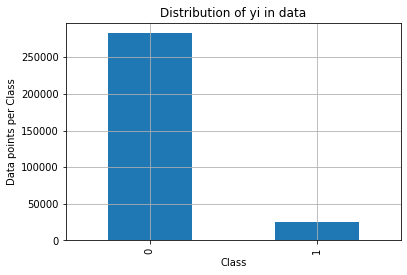

In [ ]:
# it returns a dict, keys as class labels and values as the number of data points in that class
data_distribution = app_train_with_prev_app_prev_balance_df['TARGET'].value_counts()

my_colors = 'rgbkymc'
data_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in data')
plt.grid()
plt.show()

# **Missing Values**

In [ ]:
# THis code gives the columns which are having null values and the null values count
#
import numpy as np
import matplotlib.pyplot as plt
total_cnt = app_train_with_prev_app_prev_balance_df.shape[0]
null_val_cnt = []
null_val_columns = []
for col in app_train_with_prev_app_prev_balance_df.columns:
  # print(col)
  null_cnt = pd.isnull(app_train_with_prev_app_prev_balance_df[col]).sum()
  if(null_cnt > 0):
    print('Null Values Count in Percentage (%) For Column : ', col, ' : is ', round((1.0 * null_cnt / total_cnt)*100.0,2), '%')
    null_val_cnt.append(null_cnt)
    null_val_columns.append(col)

print("Total No of Colums with Null values are : ", len(null_val_columns))

Null Values Count in Percentage (%) For Column :  AMT_ANNUITY  : is  0.0 %
Null Values Count in Percentage (%) For Column :  AMT_GOODS_PRICE  : is  0.09 %
Null Values Count in Percentage (%) For Column :  OWN_CAR_AGE  : is  65.99 %
Null Values Count in Percentage (%) For Column :  CNT_FAM_MEMBERS  : is  0.0 %
Null Values Count in Percentage (%) For Column :  EXT_SOURCE_1  : is  56.38 %
Null Values Count in Percentage (%) For Column :  EXT_SOURCE_2  : is  0.21 %
Null Values Count in Percentage (%) For Column :  EXT_SOURCE_3  : is  19.83 %
Null Values Count in Percentage (%) For Column :  APARTMENTS_AVG  : is  50.75 %
Null Values Count in Percentage (%) For Column :  BASEMENTAREA_AVG  : is  58.52 %
Null Values Count in Percentage (%) For Column :  YEARS_BEGINEXPLUATATION_AVG  : is  48.78 %
Null Values Count in Percentage (%) For Column :  YEARS_BUILD_AVG  : is  66.5 %
Null Values Count in Percentage (%) For Column :  COMMONAREA_AVG  : is  69.87 %
Null Values Count in Percentage (%) For C

In [ ]:
app_train_with_prev_app_prev_balance_df = app_train_with_prev_app_prev_balance_df.fillna(0)

# **ANOVA Test**

In [ ]:
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_classif

target = app_train_with_prev_app_prev_balance_df['TARGET']
data_ip = app_train_with_prev_app_prev_balance_df.drop(columns=['TARGET'])

normalized_data = preprocessing.normalize(data_ip)

selector = SelectKBest(f_classif, k=10)
selector.fit(normalized_data, target)

score_data = {'Scores':selector.scores_}
# Creates pandas DataFrame.
co = pd.DataFrame(score_data, index =data_ip.columns)

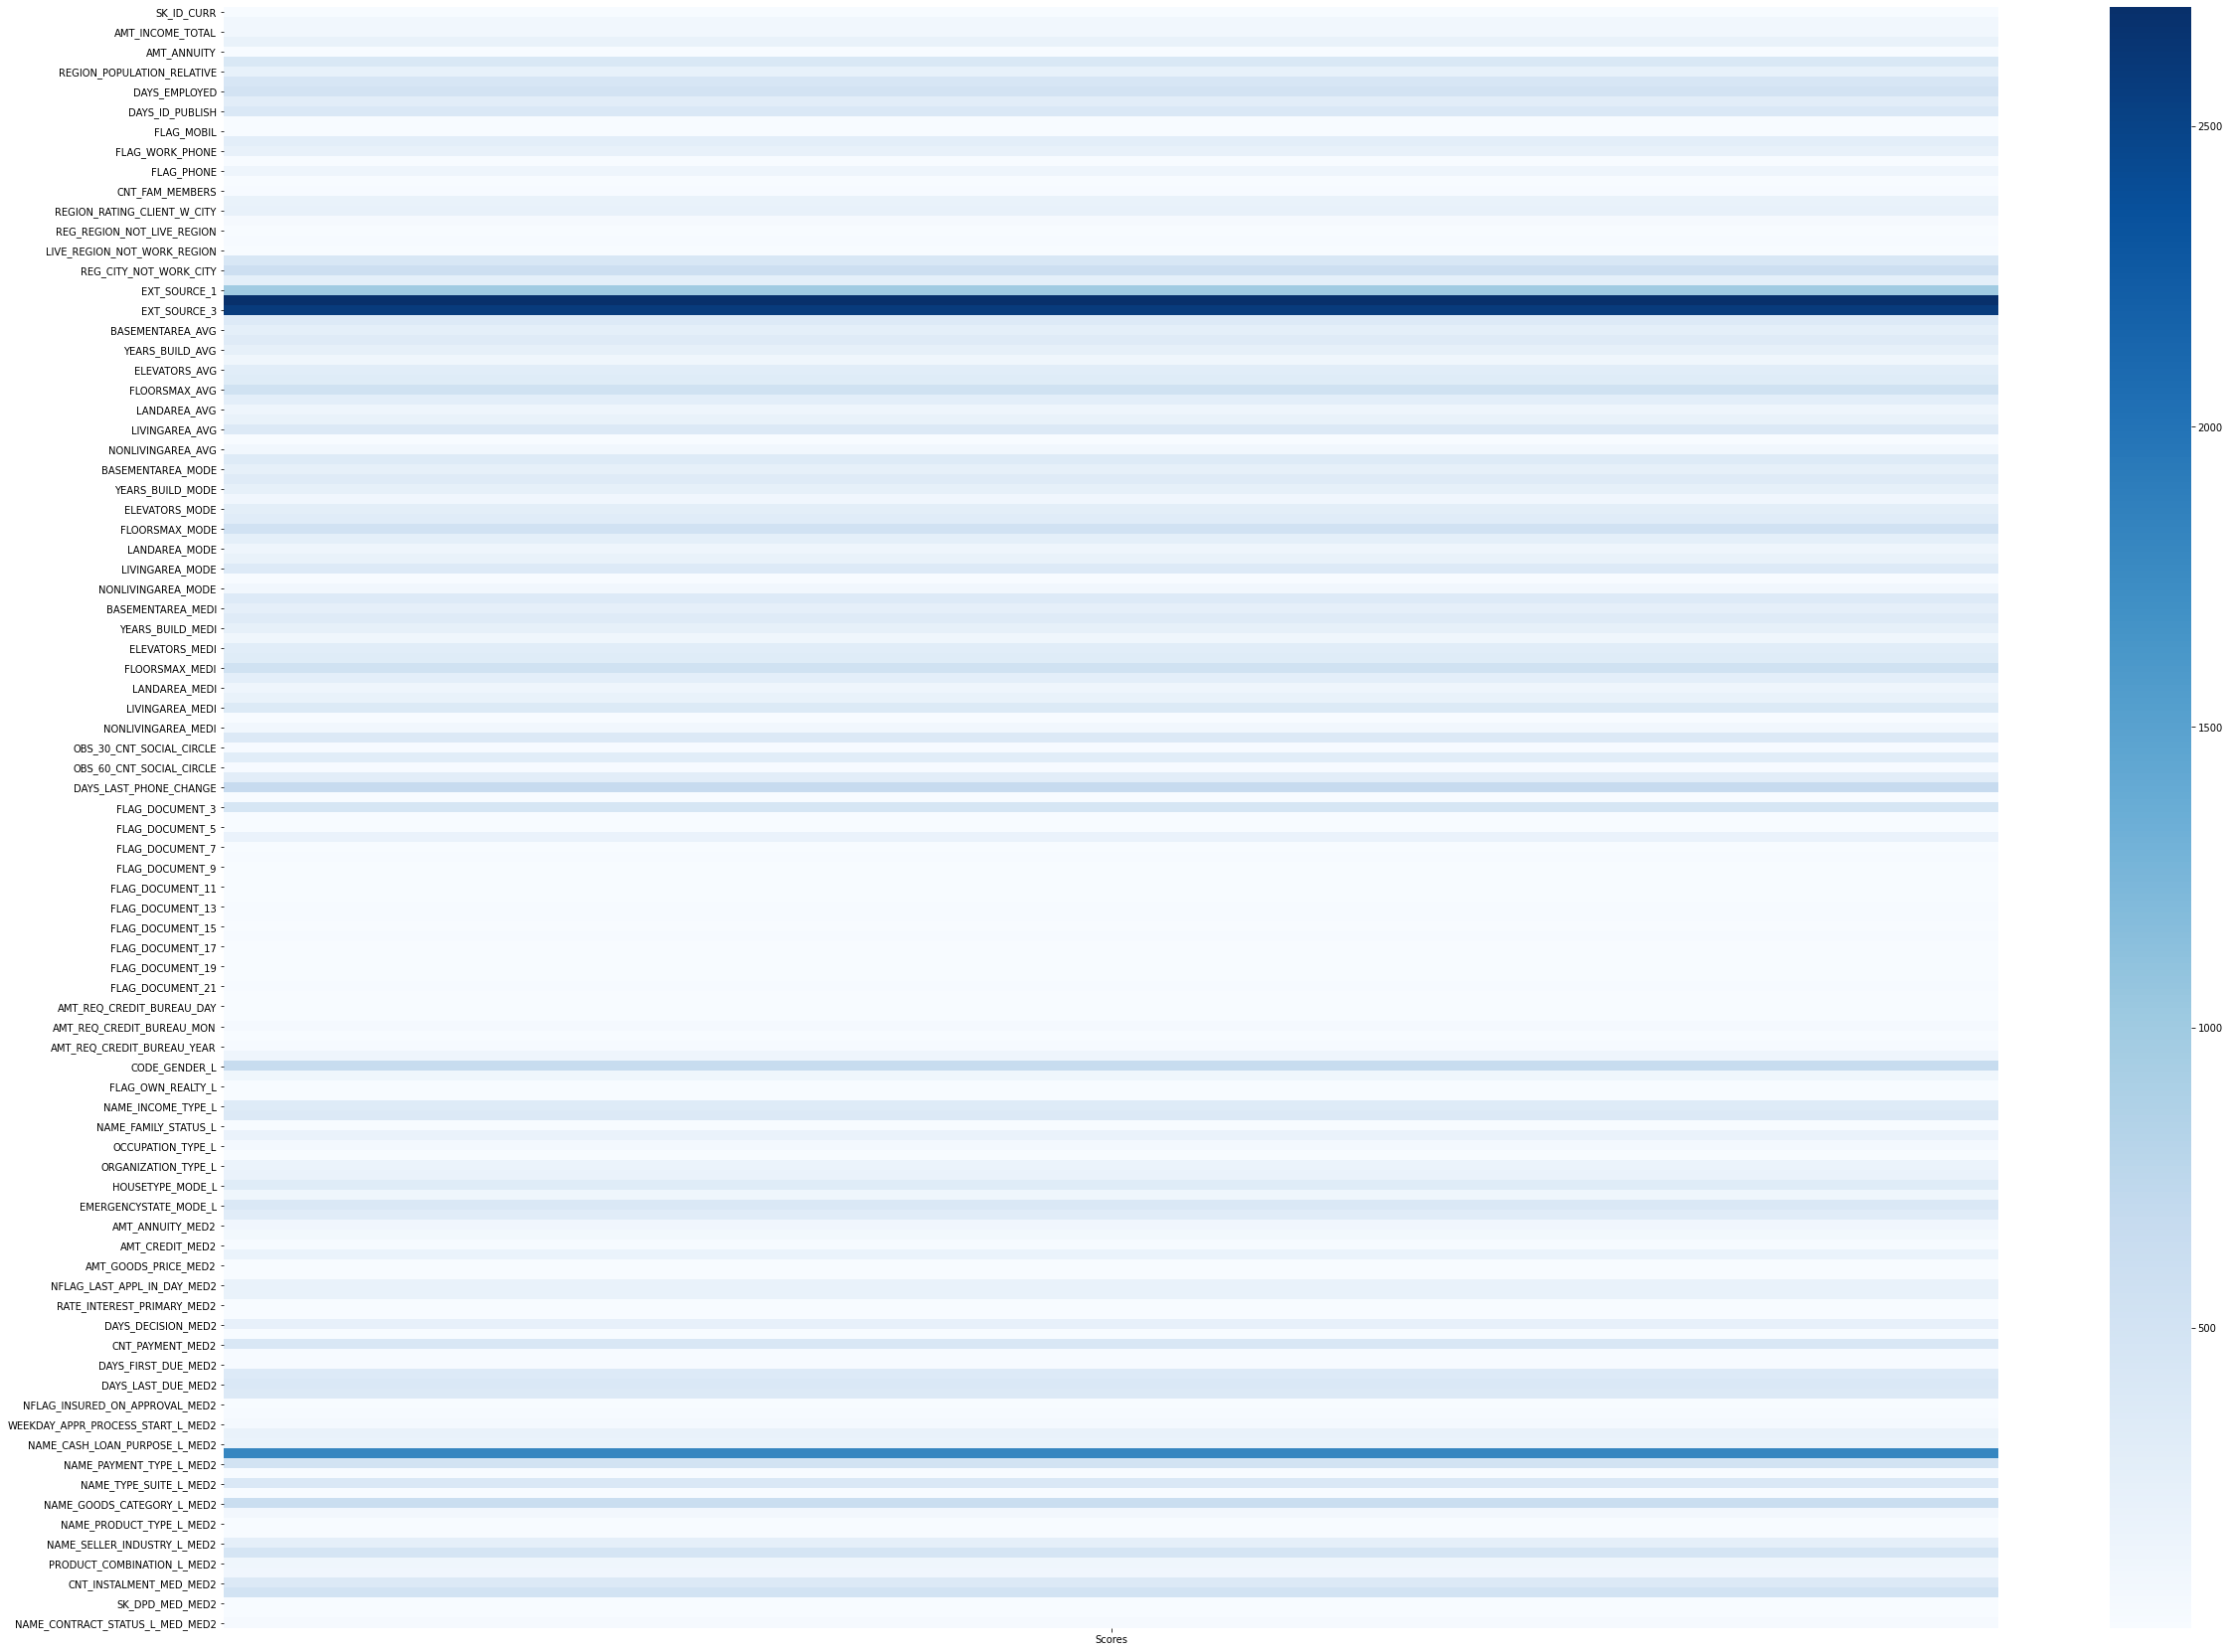

In [ ]:
plt.subplots(figsize=(40,30))
sns.heatmap(co,  cmap="Blues")

# **Analysis of Top 10 Features from ANOVA Test**

In [ ]:
top_10_features = selector.get_support(indices=True)
# print(top_10_features)
#Fetching index with descending order of highest f-score
index = np.argsort(selector.scores_[top_10_features])[::-1]
#Displaying top 10 features with descending oerder of f-score
print(data_ip.columns[top_10_features[index]])

Index(['EXT_SOURCE_2', 'EXT_SOURCE_3', 'NAME_CONTRACT_STATUS_L_MED2',
       'EXT_SOURCE_1', 'DAYS_LAST_PHONE_CHANGE', 'CODE_GENDER_L',
       'NAME_GOODS_CATEGORY_L_MED2', 'REG_CITY_NOT_WORK_CITY', 'FLOORSMAX_AVG',
       'FLOORSMAX_MEDI'],
      dtype='object')


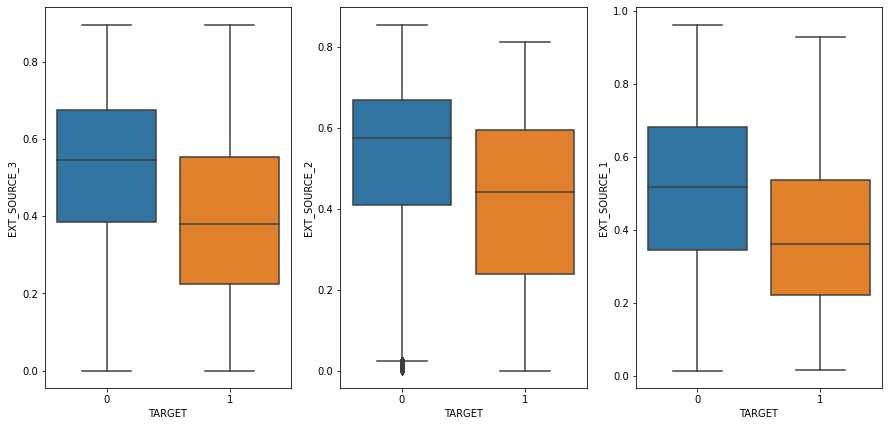

In [ ]:
# plt.subplots(figsize=(25,10))
# sns.boxplot(data=pd.melt(data[top_feat]), 
#             x='variable', y='value', hue='TARGET',data=train)
# sns.countplot(x='EXT_SOURCE_2', hue='TARGET', data=app_train,palette="Set1")
# fig, ax = plt.subplots(figsize=(15,9))
# sns.distplot(app_train['EXT_SOURCE_2'].dropna())
fig, ax = plt.subplots(ncols=3,nrows=1,figsize=(15,7))
plt.subplot(1,3,1)

sns.boxplot(x='TARGET',y='EXT_SOURCE_3',data=app_train)
# sns.displot(data=app_train, x="EXT_SOURCE_3",hue='TARGET', kde=True)
plt.subplot(1,3,2)
sns.boxplot(x='TARGET',y='EXT_SOURCE_2',data=app_train)    
plt.subplot(1,3,3)
sns.boxplot(x='TARGET',y='EXT_SOURCE_1',data=app_train)    


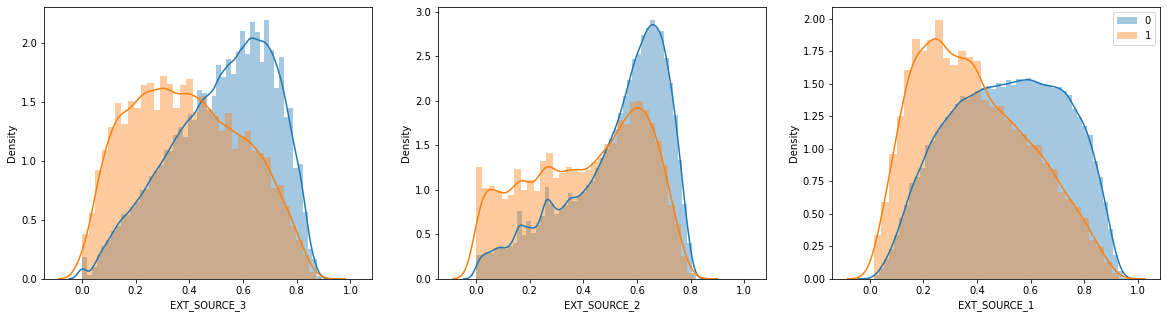

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

# print(axes)

# Sort the dataframe by target
target_0 = app_train.loc[app_train['TARGET'] == 0]
target_1 = app_train.loc[app_train['TARGET'] == 1]

sns.distplot(target_0[['EXT_SOURCE_3']], hist=True, ax=axes[0], label='0', axlabel='EXT_SOURCE_3')
sns.distplot(target_1[['EXT_SOURCE_3']], hist=True, ax=axes[0], label='1', axlabel='EXT_SOURCE_3')

sns.distplot(target_0[['EXT_SOURCE_2']], hist=True, ax=axes[1], label='0', axlabel='EXT_SOURCE_2')
sns.distplot(target_1[['EXT_SOURCE_2']], hist=True, ax=axes[1], label='1', axlabel='EXT_SOURCE_2')

sns.distplot(target_0[['EXT_SOURCE_1']], hist=True, ax=axes[2], label='0', axlabel='EXT_SOURCE_1')
sns.distplot(target_1[['EXT_SOURCE_1']], hist=True, ax=axes[2], label='1', axlabel='EXT_SOURCE_1')


plt.legend()



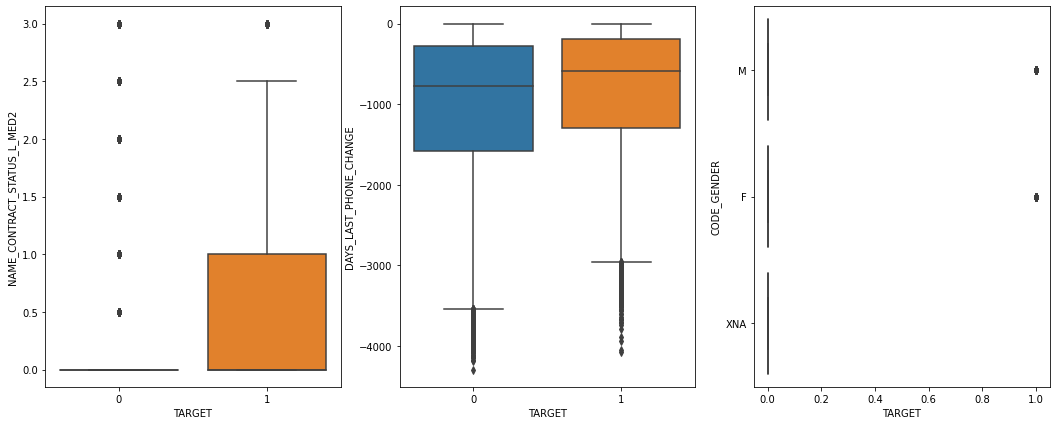

In [ ]:
fig, ax = plt.subplots(ncols=3,nrows=1,figsize=(18,7))
plt.subplot(1,3,1)

sns.boxplot(x='TARGET',y='NAME_CONTRACT_STATUS_L_MED2',data=app_train_with_prev_app_prev_balance_df)
# sns.displot(data=app_train, x="EXT_SOURCE_3",hue='TARGET', kde=True)
plt.subplot(1,3,2)
sns.boxplot(x='TARGET',y='DAYS_LAST_PHONE_CHANGE',data=app_train)    
plt.subplot(1,3,3)
sns.boxplot(x='TARGET',y='CODE_GENDER',data=app_train) 

Text(0.5, 0, 'CODE_GENDER')

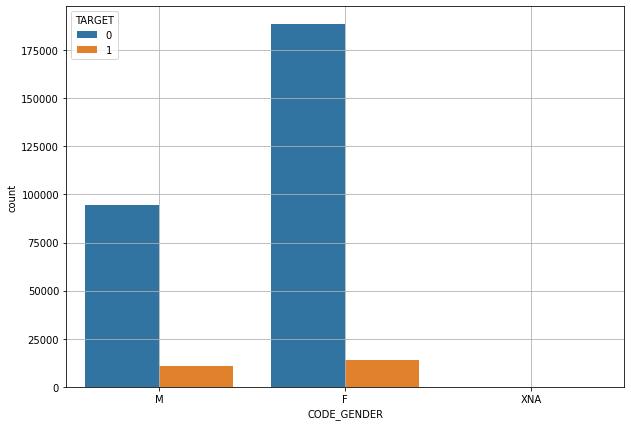

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x='CODE_GENDER',hue='TARGET',data=app_train)
plt.grid()
plt.xlabel("CODE_GENDER")

Text(0.5, 0, 'NAME_CONTRACT_STATUS')

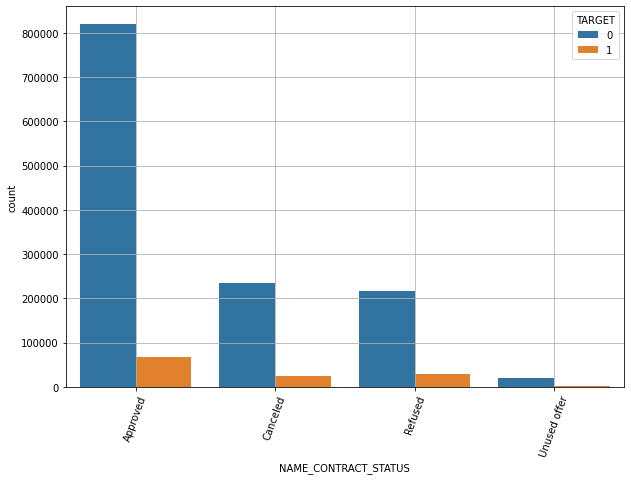

In [ ]:
# fig, ax = plt.subplots(figsize=(10,7))
# sns.countplot(x='TARGET',hue='NAME_CONTRACT_STATUS',data=app_train_joinwith_prev_app_df)

fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x='NAME_CONTRACT_STATUS',hue='TARGET',data=app_train_joinwith_prev_app_df)
plt.xticks(rotation=70)
plt.grid()
plt.xlabel("NAME_CONTRACT_STATUS")

# NAME_CONTRACT_STATUS,"Contract status (approved, cancelled, ...) of previous application",
# As per the plot, the clients whoes previous loans are approved, they will defualt more as compared the other status of previous loans.

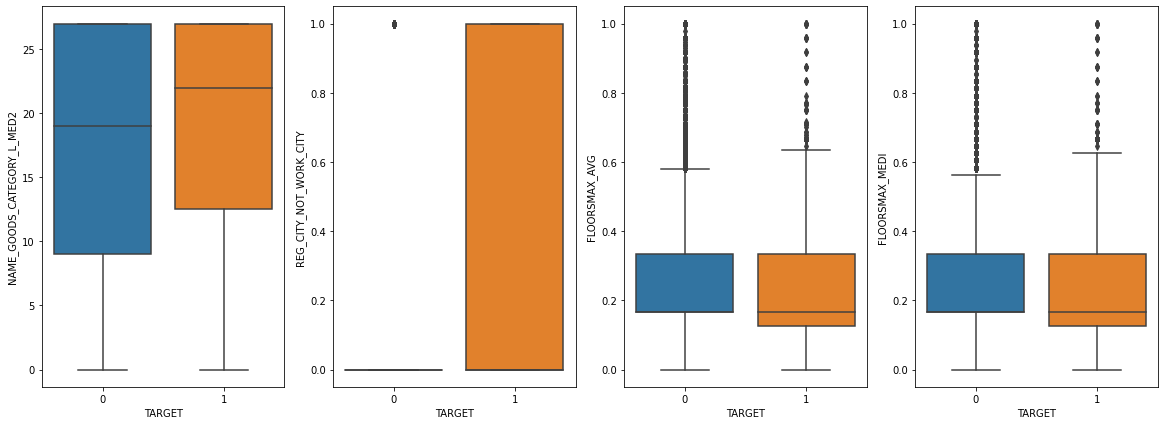

In [ ]:

fig, ax = plt.subplots(ncols=4,nrows=1,figsize=(20,7))
plt.subplot(1,4,1)

sns.boxplot(x='TARGET',y='NAME_GOODS_CATEGORY_L_MED2',data=app_train_with_prev_app_prev_balance_df)
# sns.displot(data=app_train, x="EXT_SOURCE_3",hue='TARGET', kde=True)
plt.subplot(1,4,2)
sns.boxplot(x='TARGET',y='REG_CITY_NOT_WORK_CITY',data=app_train)    
plt.subplot(1,4,3)
sns.boxplot(x='TARGET',y='FLOORSMAX_AVG',data=app_train)  
plt.subplot(1,4,4)
sns.boxplot(x='TARGET',y='FLOORSMAX_MEDI',data=app_train)        

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

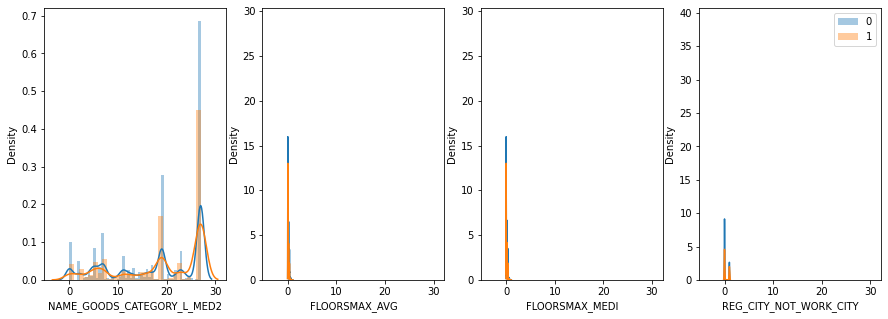

In [ ]:
f, axes = plt.subplots(1, 4, figsize=(15, 5), sharex=True)

# print(axes)

# Sort the dataframe by target
target_0 = app_train_with_prev_app_prev_balance_df.loc[app_train_with_prev_app_prev_balance_df['TARGET'] == 0]
target_1 = app_train_with_prev_app_prev_balance_df.loc[app_train_with_prev_app_prev_balance_df['TARGET'] == 1]

sns.distplot(target_0[['NAME_GOODS_CATEGORY_L_MED2']], hist=True, ax=axes[0], label='0', axlabel='NAME_GOODS_CATEGORY_L_MED2')
sns.distplot(target_1[['NAME_GOODS_CATEGORY_L_MED2']], hist=True, ax=axes[0], label='1', axlabel='NAME_GOODS_CATEGORY_L_MED2')

sns.distplot(target_0[['FLOORSMAX_AVG']], hist=True, ax=axes[1], label='0', axlabel='FLOORSMAX_AVG')
sns.distplot(target_1[['FLOORSMAX_AVG']], hist=True, ax=axes[1], label='1', axlabel='FLOORSMAX_AVG')

sns.distplot(target_0[['FLOORSMAX_MEDI']], hist=True, ax=axes[2], label='0', axlabel='FLOORSMAX_MEDI')
sns.distplot(target_1[['FLOORSMAX_MEDI']], hist=True, ax=axes[2], label='1', axlabel='FLOORSMAX_MEDI')

target_0 = app_train.loc[app_train['TARGET'] == 0]
target_1 = app_train.loc[app_train['TARGET'] == 1]

sns.distplot(target_0[['REG_CITY_NOT_WORK_CITY']], hist=True, ax=axes[3], label='0', axlabel='REG_CITY_NOT_WORK_CITY')
sns.distplot(target_1[['REG_CITY_NOT_WORK_CITY']], hist=True, ax=axes[3], label='1', axlabel='REG_CITY_NOT_WORK_CITY')

plt.legend()

Text(0.5, 0, 'NAME_GOODS_CATEGORY')

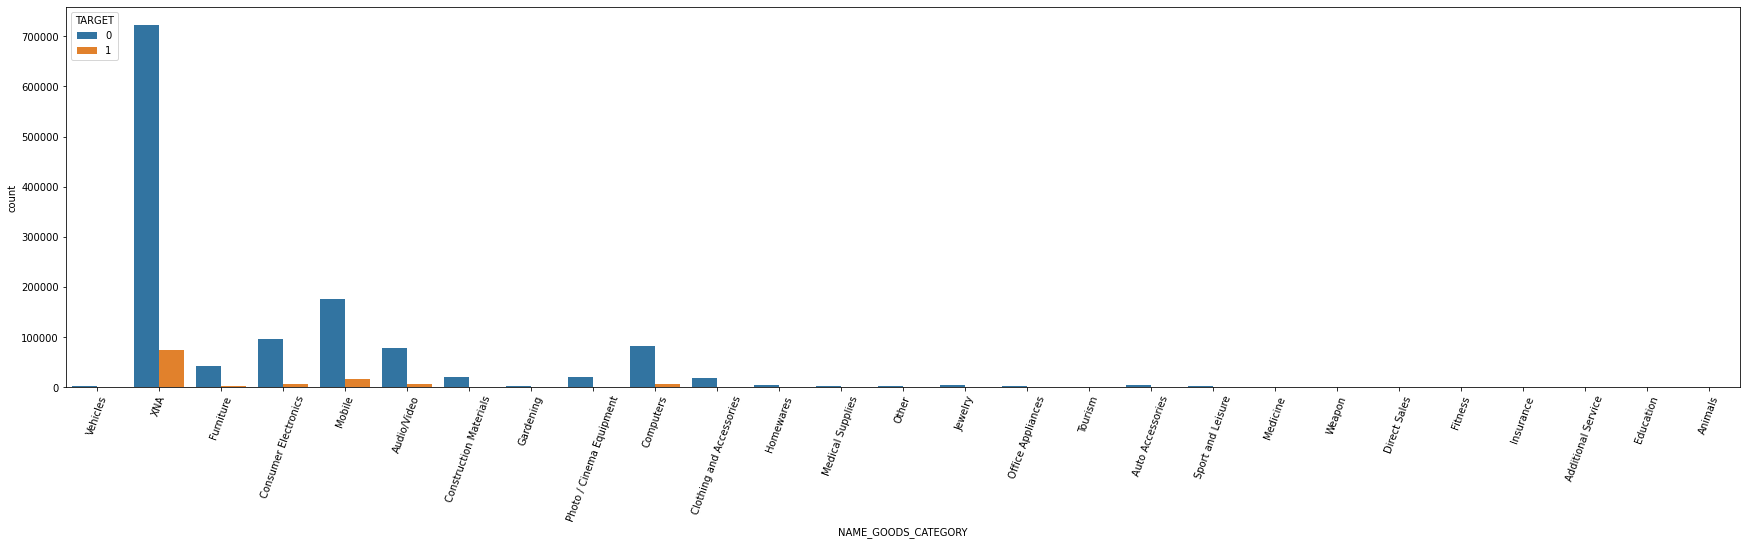

In [ ]:
fig, ax = plt.subplots(figsize=(30,7))
sns.countplot(x='NAME_GOODS_CATEGORY',hue='TARGET',data=app_train_joinwith_prev_app_df)
plt.xticks(rotation=70)
plt.xlabel("NAME_GOODS_CATEGORY")

# NAME_GOODS_CATEGORY,What kind of goods did the client apply for in the previous application
# Seems like the clients who previously taken XNA category loan will default more as compared to other categories

In [ ]:
# 1) Load the data from kaggel dataset for home-credit 
# Data Preparation:
# 2) We have taken train data and merged it with the previous loan data and performed features analysis on them.
# Ditribution of Target variables
# 3) Seems like data has very less defaulters.
# 4) then we have checked for all the missing values
# ANOVA Test
# 5) Then we applied ANOVA test on the data, to get highly correlated features
# 6) We have selected top 10 highly correlated features to perform feature analysis
# 7) We did box-plot on 'EXT_SOURCE_2', 'EXT_SOURCE_3' and 'EXT_SOURCE_1', 
#    which tell the distribution of these are bit different for class 1 and class 0
# 8) Then we did box-plot on 'NAME_CONTRACT_STATUS', 'CODE_GENDER', but we are not getting clear picture from that so we did count-plot for these features
# 9) As per the plot of CODE_GENDER, it seems like female loan applicants are having more problems in loan replayments as compared to males.
# 10) As per the plot of NAME_CONTRACT_STATUS, it can seen that, the customers whose previous loans are approved tend to default more 
#     as compared to those whoese previous loan are cancelled or refused.
# 11) NAME_GOODS_CATEGORY,What kind of goods did the client apply for in the previous application
#     Seems like the clients who previously taken XNA category loan will default more as compared to other categories
# 12) REG_CITY_NOT_WORK_CITY : "Flag if client's permanent address does not match work address (1=different, 0=same, at city level)",
#      Seems like, clients whoes work citi and home citi is same, tend to make more defaults in loan repayments

Text(0.5, 0, 'REG_CITY_NOT_WORK_CITY')

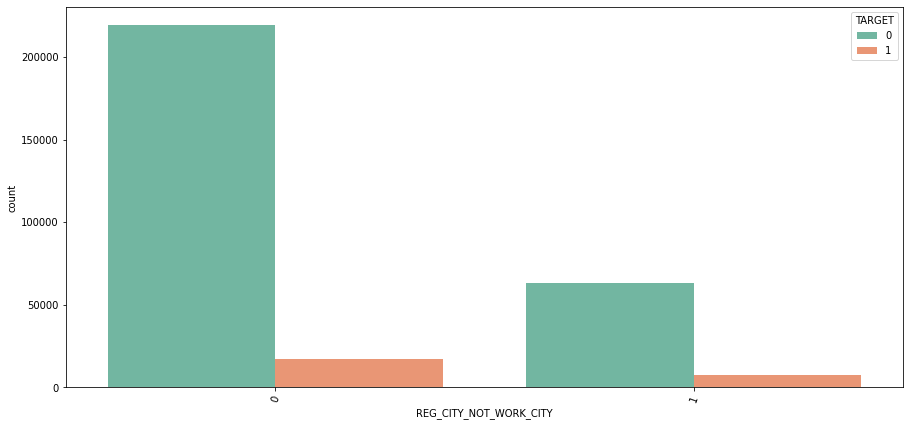

In [ ]:

fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(x='REG_CITY_NOT_WORK_CITY',hue='TARGET',data=app_train,palette="Set2")
plt.xticks(rotation=70)
plt.xlabel("REG_CITY_NOT_WORK_CITY")

# REG_CITY_NOT_WORK_CITY : "Flag if client's permanent address does not match work address (1=different, 0=same, at city level)",
# Seems like, clients whoes work citi and home citi is same tend to make defaults

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


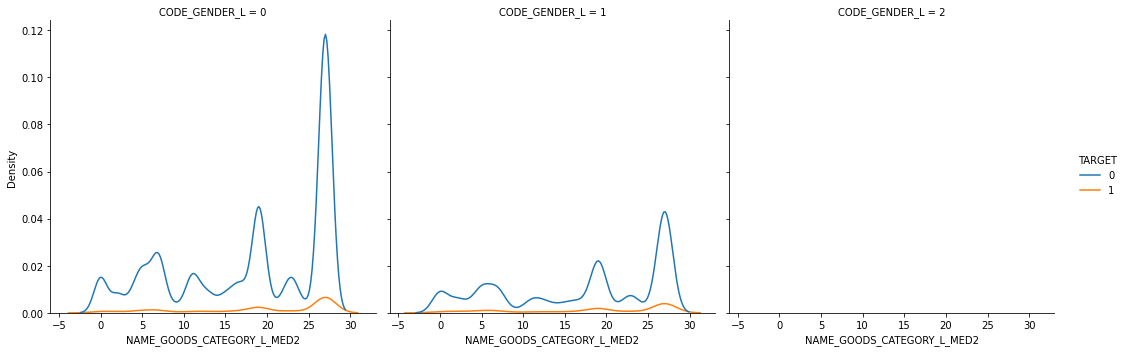

In [ ]:
# fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(15,7))
# plt.subplot(1,2,1)
# sns.displot(app_train_with_prev_app_prev_balance_df, x="NAME_GOODS_CATEGORY_L_MED2", hue="TARGET", kind="kde", fill=True)
# plt.subplot(1,2,2)
# sns.displot(app_train_with_prev_app_prev_balance_df, x="REG_CITY_NOT_WORK_CITY", hue="TARGET", kind="kde", fill=True)

sns.displot(data=app_train_with_prev_app_prev_balance_df, x="NAME_GOODS_CATEGORY_L_MED2", hue="TARGET", col="CODE_GENDER_L", kind="kde")

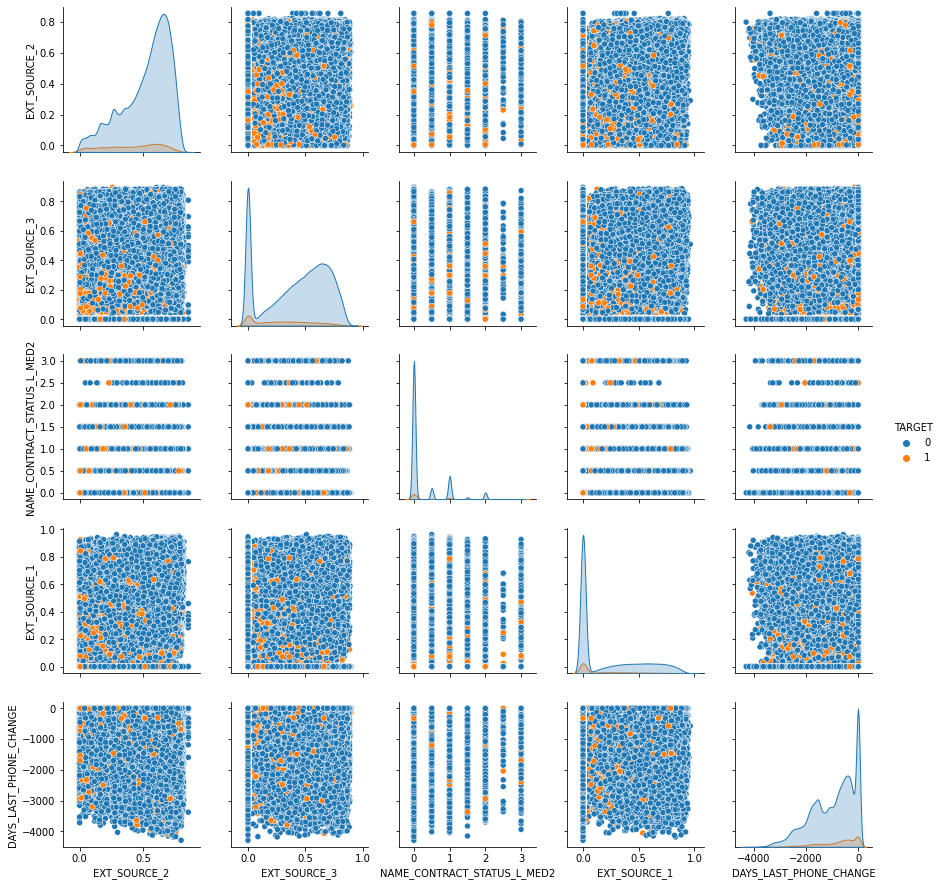

In [ ]:
#Bivariate Analysis on the continuous features

# g = sns.PairGrid(df, vars=['DAYS_BIRTH','REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT','DAYS_LAST_PHONE_CHANGE','DAYS_ID_PUBLISH'], hue="TARGET")
# g.map(sns.displot)

sns.pairplot(app_train_with_prev_app_prev_balance_df, vars=['EXT_SOURCE_2', 'EXT_SOURCE_3', 'NAME_CONTRACT_STATUS_L_MED2',
       'EXT_SOURCE_1', 'DAYS_LAST_PHONE_CHANGE'],
             hue="TARGET", height=2.5)

# **Customer already having many loans will default the loan or not ?**

In [ ]:
app_train_df = pd.read_csv('application_train.csv')
print(app_train_df.shape)
non_defaulted_df = app_train_df[app_train_df['TARGET'] == 0]
print(non_defaulted_df.shape)
defaulted_df = app_train_df[app_train_df['TARGET'] == 1]
defaulted_df.shape

(307511, 122)
(282686, 122)


(24825, 122)

In [ ]:
# non_defaulted_df.head()

In [ ]:
# defaulted_df.head()

In [ ]:
prev_aap_df = pd.read_csv('previous_application.csv')

In [ ]:
# prev_aap_df.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
non_defaulted_merged = pd.merge(non_defaulted_df,prev_aap_df,on='SK_ID_CURR')
# non_defaulted_merged.head()

Maximum number of loans taken: 73



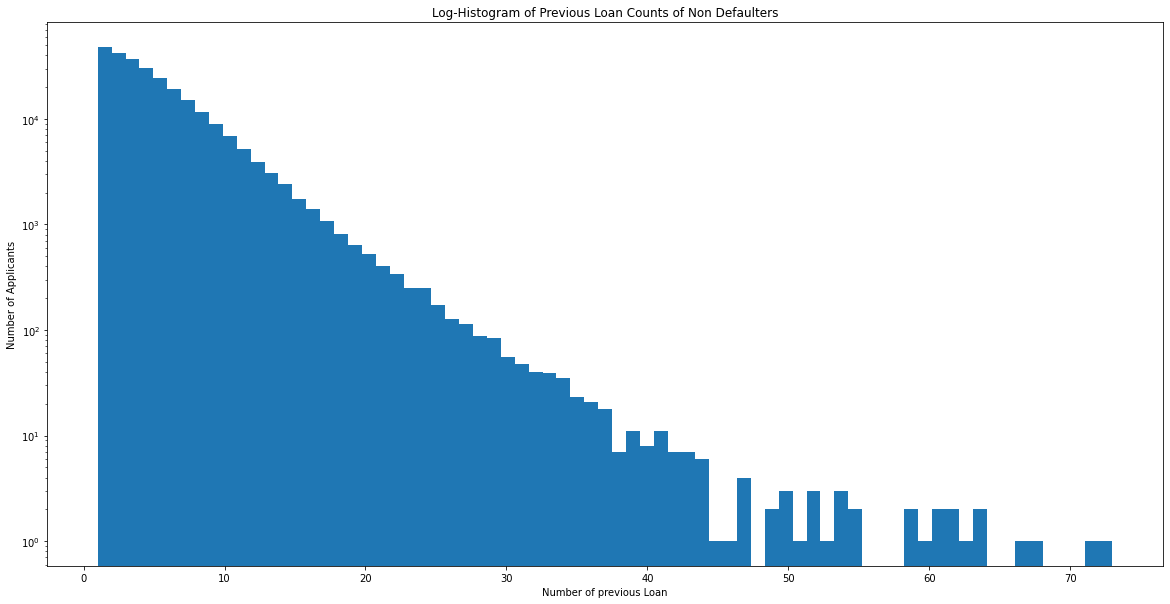

In [ ]:
plt.figure(figsize=(20, 10))
plt.hist(non_defaulted_merged["SK_ID_CURR"].value_counts(), bins=73)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of Previous Loan Counts of Non Defaulters')
plt.xlabel('Number of previous Loan')
plt.ylabel('Number of Applicants')
print ('Maximum number of loans taken: {}\n'.format(max(non_defaulted_merged["SK_ID_CURR"].value_counts()))) 

In [ ]:
defaulted_merged = pd.merge(defaulted_df,prev_aap_df,on='SK_ID_CURR')

Maximum number of loans taken: 60



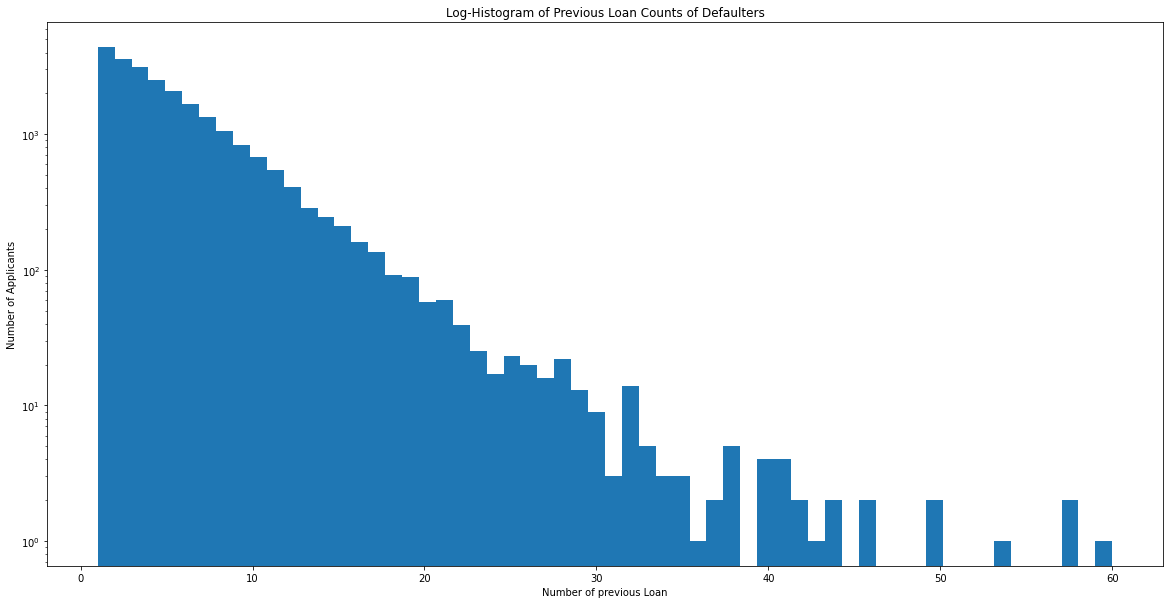

In [ ]:
plt.figure(figsize=(20, 10))
plt.hist(defaulted_merged["SK_ID_CURR"].value_counts(), bins=60)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of Previous Loan Counts of Defaulters')
plt.xlabel('Number of previous Loan')
plt.ylabel('Number of Applicants')
print ('Maximum number of loans taken: {}\n'.format(max(defaulted_merged["SK_ID_CURR"].value_counts()))) 

In [ ]:
# above are the plots of previous loan counts of non defaulters and defaulters.
# as per the plot we could both deafulters and non-defaulters borrowed many loan
# we can also non-defaulters in fact borrowed mroe number of loan.
# So as per these plots, we can't say that the customer having many previous loans will default 

In [ ]:
cred_card_bal_df = pd.read_csv('credit_card_balance.csv')
cred_card_bal_df.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [ ]:
non_defaulted_merged = pd.merge(non_defaulted_df,cred_card_bal_df,on='SK_ID_CURR')
# non_defaulted_merged.head()

Maximum number of Credit Card loans taken: 192



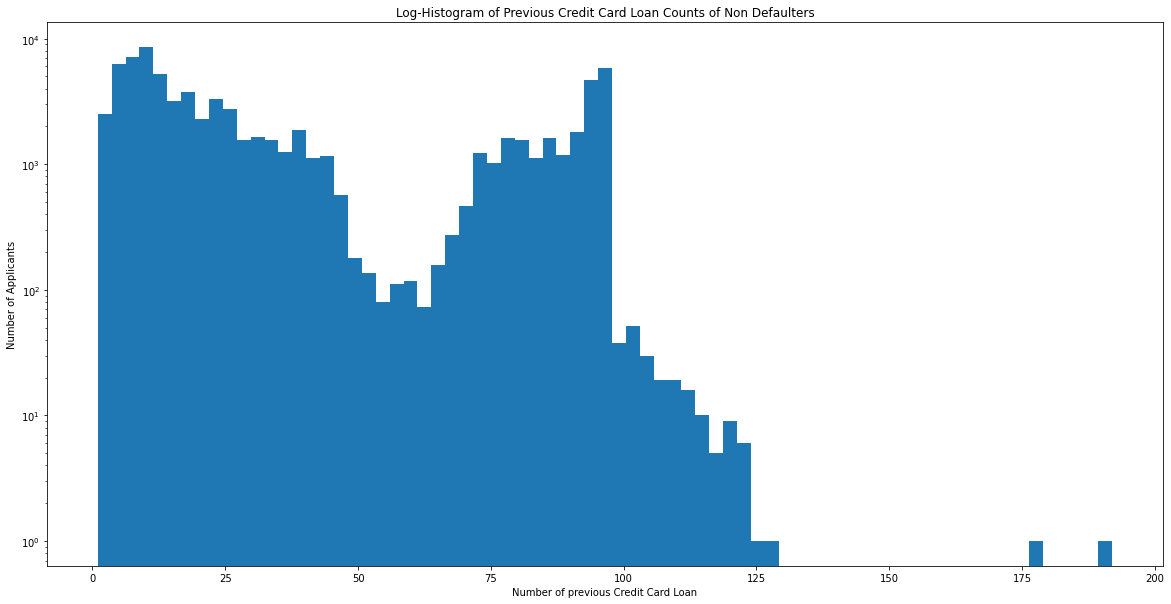

In [ ]:
plt.figure(figsize=(20, 10))
plt.hist(non_defaulted_merged["SK_ID_CURR"].value_counts(), bins=73)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of Previous Credit Card Loan Counts of Non Defaulters')
plt.xlabel('Number of previous Credit Card Loan')
plt.ylabel('Number of Applicants')
print ('Maximum number of Credit Card loans taken: {}\n'.format(max(non_defaulted_merged["SK_ID_CURR"].value_counts()))) 

In [ ]:
defaulted_merged = pd.merge(defaulted_df,cred_card_bal_df,on='SK_ID_CURR')

Maximum number of Credit Card loans taken: 124



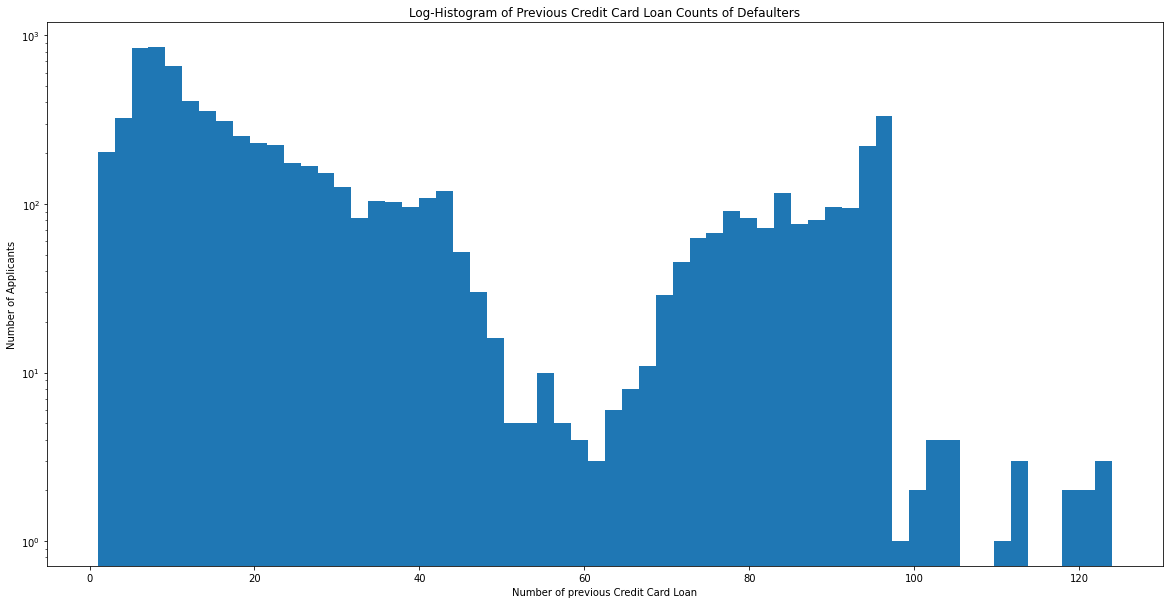

In [ ]:
plt.figure(figsize=(20, 10))
plt.hist(defaulted_merged["SK_ID_CURR"].value_counts(), bins=60)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of Previous Credit Card Loan Counts of Defaulters')
plt.xlabel('Number of previous Credit Card Loan')
plt.ylabel('Number of Applicants')
print ('Maximum number of Credit Card loans taken: {}\n'.format(max(defaulted_merged["SK_ID_CURR"].value_counts()))) 

In [ ]:

# Just like previous loans, we can't say that the customer having many previous credit card loans will default 

# **Feature Engineering - Auto Encoders**

In [ ]:
from sklearn import preprocessing

# target = data['TARGET']
# data_ip = data.drop(columns=['TARGET'])
n_inputs = data_ip.shape[1]

In [ ]:
# REF : https://machinelearningmastery.com/autoencoder-for-classification/
from sklearn.preprocessing import MinMaxScaler
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(data_ip, target, test_size=0.20, random_state=1, stratify=target)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_cv = t.transform(X_cv)
X_test = t.transform(X_test)

In [ ]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
# define encoder
input = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(input)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = round(float(n_inputs) / 2.0)
bottleneck = Dense(n_bottleneck)(e)

In [ ]:
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)

Epoch 1/10
12301/12301 [==============================] - 83s 7ms/step - loss: 0.0092 - val_loss: 0.0059
Epoch 2/10
12301/12301 [==============================] - 81s 7ms/step - loss: 0.0063 - val_loss: 0.0051
Epoch 3/10
12301/12301 [==============================] - 82s 7ms/step - loss: 0.0055 - val_loss: 0.0031
Epoch 4/10
12301/12301 [==============================] - 81s 7ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 5/10
12301/12301 [==============================] - 80s 6ms/step - loss: 0.0045 - val_loss: 0.0024
Epoch 6/10
12301/12301 [==============================] - 79s 6ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 7/10
12301/12301 [==============================] - 79s 6ms/step - loss: 0.0041 - val_loss: 0.0029
Epoch 8/10
12301/12301 [==============================] - 80s 6ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 9/10
12301/12301 [==============================] - 79s 6ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 10/10
12301/12301 [==============================

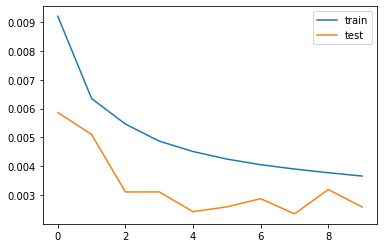

In [ ]:
# define autoencoder model
model = Model(inputs=input, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')
# plot the autoencoder
plot_model(model, 'autoencoder_no_compress.png', show_shapes=True)
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=10, batch_size=16, verbose=1, validation_data=(X_test,X_test))
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# define an encoder model (without the decoder)
encoder = Model(inputs=input, outputs=bottleneck)
plot_model(encoder, 'encoder_compress.png', show_shapes=True)
# save the encoder to file
encoder.save('encoder.h5')

In [ ]:

from tensorflow.keras.models import load_model
# load the model from file
encoder = load_model('encoder.h5')
# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the cv data
X_cv_encode = encoder.predict(X_cv)
# encode the test data
X_test_encode = encoder.predict(X_test)

# This way we have used auto-encoder to create new features, we will concatenate this new features with the existing features.

In [ ]:
X_train_encode.shape, X_test_encode.shape, X_cv_encode.shape

((196806, 82), (61503, 82), (49202, 82))

In [ ]:
X_train_with_encoded_feat = np.hstack((X_train, X_train_encode))
X_cv_with_encoded_feat = np.hstack((X_cv, X_cv_encode))
X_test_with_encoded_feat = np.hstack((X_test, X_test_encode))
X_train_with_encoded_feat.shape, X_test_with_encoded_feat.shape, X_cv_with_encoded_feat.shape

((196806, 245), (61503, 245), (49202, 245))

In [ ]:
auto_enc_columns = [ 'AUTO_ENC_FEAT_'+ str(i) for i in range(X_train_encode.shape[1])]

In [ ]:
# cols = data_ip.columns + auto_enc_columns
cols = np.concatenate((data_ip.columns, auto_enc_columns), axis=None)

In [ ]:
len(cols)

245

In [ ]:
# creating the dataframe
X_train_with_encoded_feat_df = pd.DataFrame(data = X_train_with_encoded_feat, columns = cols)
X_cv_with_encoded_feat_df = pd.DataFrame(data = X_cv_with_encoded_feat, columns = cols)
X_test_with_encoded_feat_df = pd.DataFrame(data = X_test_with_encoded_feat, columns = cols)
X_train_with_encoded_feat_df.shape, X_test_with_encoded_feat_df.shape, X_cv_with_encoded_feat_df.shape

((196806, 245), (61503, 245), (49202, 245))

In [ ]:
import pickle

In [ ]:
#save all your results to disk so that, no need to run all again. 
pickle.dump((X_train_with_encoded_feat_df, y_train),open('/content/drive/MyDrive/data/Self-Case-Study-1/train_data.pkl','wb'))
pickle.dump((X_cv_with_encoded_feat_df, y_cv),open('/content/drive/MyDrive/data/Self-Case-Study-1/cv_data.pkl','wb'))
pickle.dump((X_test_with_encoded_feat_df, y_test),open('/content/drive/MyDrive/data/Self-Case-Study-1/test_data.pkl','wb'))

In [ ]:
#you can load from disk
X_train_with_encoded_feat_df, y_train = pickle.load(open("/content/drive/MyDrive/data/Self-Case-Study-1/train_data.pkl", 'rb')) 
X_test_with_encoded_feat_df, y_test = pickle.load(open("/content/drive/MyDrive/data/Self-Case-Study-1/test_data.pkl", 'rb'))

In [ ]:
# 1) Load the data from kaggel dataset for home-credit 

# Data Preparation:
# 2) We have taken train data and merged it with the previous loan data and performed features analysis on them.

# Ditribution of Target variables
# 3) Seems like data has very less defaulters.
# 4) then we have checked for all the missing values

# ANOVA Test
# 5) Then we applied ANOVA test on the data, to get highly correlated features
# 6) We have selected top 10 highly correlated features to perform feature analysis

# Feature Analysis
# 7) We did box-plot on 'EXT_SOURCE_2', 'EXT_SOURCE_3' and 'EXT_SOURCE_1', 
#    which tell the distribution of these are bit different for class 1 and class 0
# 8) Then we did box-plot on 'NAME_CONTRACT_STATUS', 'CODE_GENDER', but we are not getting clear picture from that so we did count-plot for these features
# 9) As per the plot of CODE_GENDER, it seems like female loan applicants are having more problems in loan replayments as compared to males.
# 10) As per the plot of NAME_CONTRACT_STATUS, it can seen that, the customers whose previous loans are approved tend to default more 
#     as compared to those whoese previous loan are cancelled or refused.
# 11) NAME_GOODS_CATEGORY,What kind of goods did the client apply for in the previous application
#     Seems like the clients who previously taken XNA category loan will default more as compared to other categories
# 12) REG_CITY_NOT_WORK_CITY : "Flag if client's permanent address does not match work address (1=different, 0=same, at city level)",
#      Seems like, clients whoes work citi and home citi is same, tend to make more defaults in loan repayments
#  13) We also have plot the pair-plot of few feature to check the interaction bewtween them.

# 14) In addtion to this, we have segregated the clients in two groups as non defaulters and defaulters.
#     then, we extracted the data of numbers loans have already borrowed
#     As per the analysis, it seems like, non-defaulters have more numbers of previous loans as compared to defaulters.
#     So its difficult to conclude that, customer who had already taken many loan will default the new loan.

# 15) Same analysis has been done on customers who have credit loans.
#     Here also, we found the same behaviour, that non-defaulters have taken more credit card loans as compared to defaulters
#     So here also, it can't be concluded that, customers who took many credit card loan will default the new loan.

# Feature Engineering
# 1) We have used auto encoders for features enginnering.
# 2) Here we have created simple encoder - decoder network. encoder (2-layers), decoder (2-layers)
# 3) We have passed x_train data to encoder, encoder gives encodes output and pass it to decoder, decoder then decode it.
# 4) we calculate the loss between predicted output of decoder and X_train data. and try to minimize that
# 5) We trained the network for 10 epochs which gives us 0.002 loss.
# 6) Then we have used only used this already trained encoder layers to encode the x_train and x_cv and x_Test data.
# 7) this will return encoded values which we can use as new feature in the dataset by concatenating them with the input features.
# 8) After concatenated them we have this preprossed data in pickel file to use it while building models